Survival analysis
=================

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import marriage

import thinkstats2
import thinkplot

import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as pyplot
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

%matplotlib inline

Load the data:

In [2]:
resp8 = marriage.ReadFemResp2013()
marriage.Validate2013(resp8)

resp7 = marriage.ReadFemResp2010()
marriage.Validate2010(resp7)

resp6 = marriage.ReadFemResp2002()
marriage.Validate2002(resp6)

resp5 = marriage.ReadFemResp1995()
marriage.Validate1995(resp5)

resp4 = marriage.ReadFemResp1988()
marriage.Validate1988(resp4)

resp3 = marriage.ReadFemResp1982()
marriage.Validate1982(resp3)

Make a list of DataFrames, one for each cycle:

In [3]:
resps = [resp8, resp7, resp6, resp5, resp4, resp3]

Make a table showing the number of respondents in each cycle:

In [4]:
def SummarizeCycle(df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900

    print('# & ', intvws.astype(int), '&', len(df), '&', births.astype(int), r'\\')
    
for resp in reversed(resps):
    SummarizeCycle(resp)

# &  [1982 1983] & 7969 & [1937 1968] \\
# &  [1988 1988] & 8450 & [1943 1973] \\
# &  [1995 1995] & 10847 & [1950 1980] \\
# &  [2002 2003] & 7643 & [1957 1988] \\
# &  [2006 2010] & 12279 & [1961 1995] \\
# &  [2011 2013] & 5601 & [1966 1998] \\


Check for missing values in `agemarry`:

In [5]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for resp in resps:
    CheckAgeVars(resp)

17
16
37
0
0
0


Combine the DataFrames (but remember that this is not resampled properly):

In [6]:
df = pd.concat(resps, ignore_index=True)
len(df)

52789

Double check missing data:

In [7]:
df['missing'] = (df.evrmarry & df.agemarry.isnull())
sum(df.missing)

70

Test run the resampling process:

Generate a table with the number of respondents in each cohort (not resampled):

In [9]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()), '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42 -- 44 & 310 & 0 \\
40 & 3608 & 32 -- 44 & 3275 & 0 \\
50 & 10631 & 22 -- 44 & 8658 & 10 \\
60 & 14484 & 15 -- 44 & 8421 & 27 \\
70 & 12083 & 14 -- 43 & 5908 & 25 \\
80 & 8536 & 14 -- 33 & 2203 & 8 \\
90 & 3122 & 15 -- 23 & 93 & 0 \\


Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function using the CDF.

$SF(t) = 1 - CDF(t)$

In [10]:
from marriage import SurvivalFunction

def MakeSurvivalFunction(values, label=''):
    cdf = thinkstats2.Cdf(values)
    xs = cdf.xs
    ss = 1 - cdf.ps
    return SurvivalFunction(xs, ss, label)

Select the 30s cohort and make the plot.

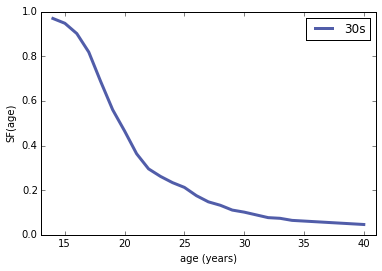

In [11]:
cohort = grouped.get_group(30)
sf = MakeSurvivalFunction(cohort.agemarry_index.fillna(np.inf))

thinkplot.PrePlot(2)
thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlabel='age (years)',
                 ylabel='SF(age)',
                 xlim=[13, 41])

Then use the SurvivalFunction to compute the HazardFunction

$HF(t) = \frac{SF(x) - SF(x+1)}{SF(x)}$

    def MakeHazardFunction(self, label=''):
        """Computes the hazard function.

        This simple version does not take into account the
        spacing between the ts.  If the ts are not equally
        spaced, it is not valid to compare the magnitude of
        the hazard function across different time steps.

        label: string

        returns: HazardFunction object
        """
        lams = pd.Series(index=self.ts)

        prev = 1.0
        for t, s in zip(self.ts, self.ss):
            lams[t] = (prev - s) / prev
            prev = s

        return HazardFunction(lams, label=label)

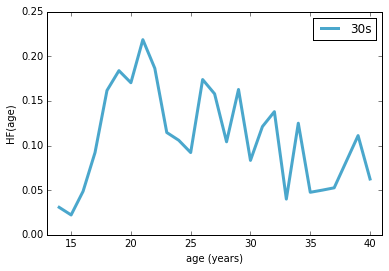

In [12]:
hf = sf.MakeHazardFunction()

thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlabel='age (years)',
                 ylabel='HF(age)',
                 xlim=[13, 41])

Here's the function that implements Kaplan-Meier estimation (http://en.wikipedia.org/wiki/Kaplan-Meier_estimator)

The kernel of the algorithm is

$HF(t) = \mbox{ended}(t) / \mbox{at_risk}(t)$ 

In [13]:
from collections import Counter

def EstimateHazard(complete, ongoing, label=''):
    """Estimates the hazard function by Kaplan-Meier.


    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    """
    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        at_risk -= ended + censored

    return marriage.HazardFunction(lams, label=label)

As an example, I select the 40s cohort, extract `complete` and `ongoing`, and estimate the hazard function.

In [17]:
sample = marriage.ResampleResps(resps)
grouped = sample.groupby('birth_index')
group = grouped.get_group(40)

complete = group[group.evrmarry].agemarry_index
ongoing = group[~group.evrmarry].age_index

print('age', 'atRisk', 'ended', 'censor', 'hf', sep='\t')
hf = marriage.EstimateHazard(complete, ongoing, label='', verbose=True)

age	atRisk	ended	censor	hf
14.0	4031	63	0	0.0156288762094
15.0	3968	97	0	0.0244455645161
16.0	3871	182	0	0.0470162748644
17.0	3689	343	0	0.0929791271347
18.0	3346	458	0	0.136879856545
19.0	2888	491	0	0.170013850416
20.0	2397	441	0	0.183979974969
21.0	1956	394	0	0.201431492843
22.0	1562	310	0	0.198463508323
23.0	1252	225	0	0.179712460064
24.0	1027	169	0	0.164556962025
25.0	858	132	0	0.153846153846
26.0	726	84	0	0.115702479339
27.0	642	77	0	0.119937694704
28.0	565	62	0	0.109734513274
29.0	503	36	0	0.0715705765408
30.0	467	39	1	0.0835117773019
31.0	427	32	3	0.0749414519906
32.0	392	16	16	0.0408163265306
33.0	360	14	21	0.0388888888889
34.0	325	15	23	0.0461538461538
35.0	287	14	29	0.0487804878049
36.0	244	5	27	0.0204918032787
37.0	212	3	16	0.0141509433962
38.0	193	5	29	0.0259067357513
39.0	159	5	39	0.0314465408805
40.0	115	0	41	0.0
41.0	74	1	32	0.0135135135135
42.0	41	1	16	0.0243902439024
43.0	24	0	14	0.0
44.0	10	0	10	0.0


Here's what the hazard function looks like.

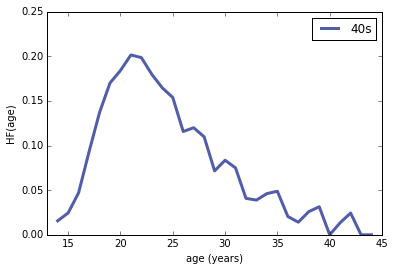

In [18]:
thinkplot.PrePlot(1)
thinkplot.Plot(hf, label='40s')
thinkplot.Config(xlabel='age (years)',
                 ylabel='HF(age)',
                 xlim=[13, 45])

Given the hazard function, we can compute the survival function as a cumulative product.

$SF(t) = \prod_{t_i < t}[1 - HF(t)]$

In order to survive until $t$, you have to not die at each time prior to $t$.

    # in class HazardFunction
    def MakeSurvival(self, label=''):
        """Makes the survival function.

        returns: SurvivalFunction
        """
        series = (1 - self.series).cumprod()
        ts = series.index.values
        ss = series.values
        return SurvivalFunction(ts, ss, label=label)


Here's the same thing encapsulated in a function.

In [19]:
def EstimateSurvival(resp, cutoff=None):
    """Estimates the survival curve.

    resp: DataFrame of respondents
    cutoff: where to truncate the estimated functions

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.evrmarry].agemarry_index
    ongoing = resp[~resp.evrmarry].age_index

    hf = EstimateHazard(complete, ongoing, jitter=0)
    if cutoff:
        hf.Truncate(cutoff)
    sf = hf.MakeSurvival()

    return hf, sf

Now we can iterate through the cohorts and plot the survival function for each.

In [20]:
sample = marriage.ResampleResps(resps)
grouped = sample.groupby('birth_index')

cutoffs = {70:43, 80:33, 90:23}
cohorts = [90, 80, 70, 60, 50, 40]

thinkplot.PrePlot(len(cohorts))
for cohort in cohorts:
    group = grouped.get_group(cohort)
    cutoff = cutoffs.get(cohort)
    hf, sf = EstimateSurvival(group, cutoff)

    thinkplot.Plot(sf, label=cohort)
             
thinkplot.Config(xlabel='age (years)',
                 ylabel='SF(age)')

TypeError: EstimateHazard() got an unexpected keyword argument 'jitter'

A couple of observations:

1) People are getting married later and later.

2) In the first few cohorts the fraction of people who never married was increasing only slowly.  It looks like that might be accelerating in the more recent cohorts.

Note that this is based on resampled data, so it will look slightly different each time.  By running several iteration, we can quantify variability due to sampling.  It turns out to be quite small.